In [1]:
import numpy as np

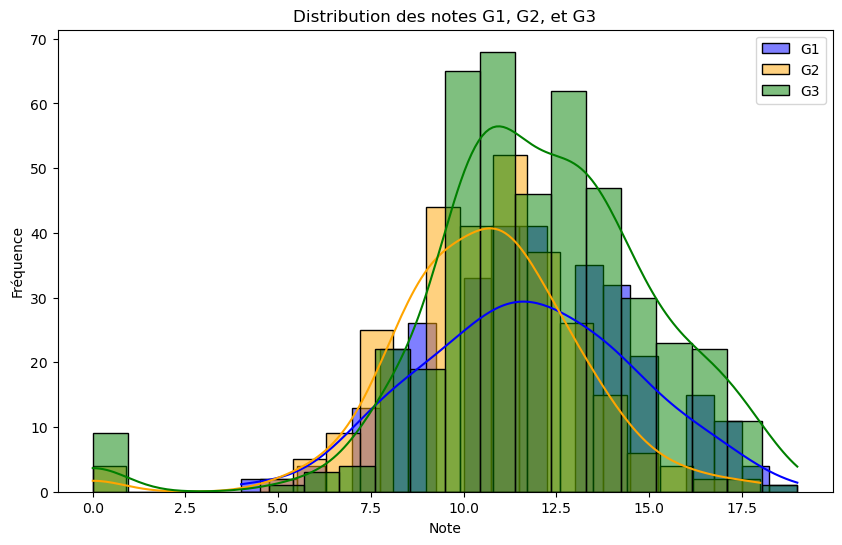

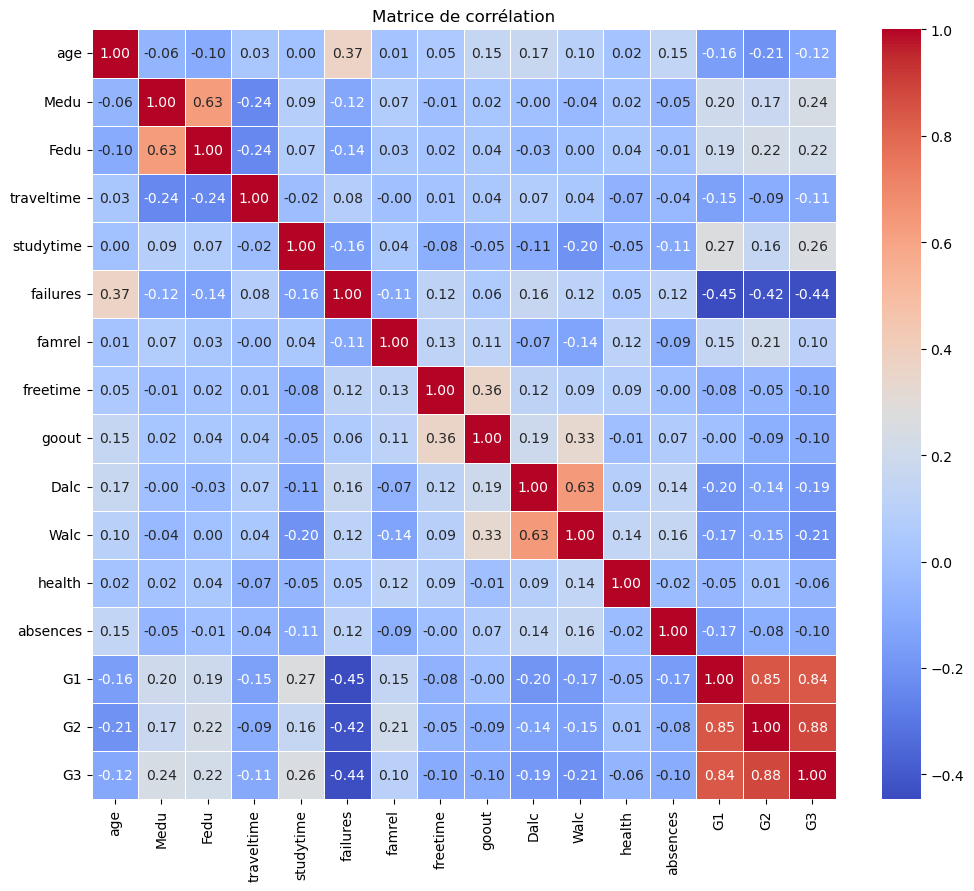

KeyError: 0

<Figure size 800x600 with 0 Axes>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données (remplacer 'path_to_your_file.csv' par le chemin de votre fichier)
data = pd.read_csv('data/data_train.csv', delimiter='\t', quotechar='"')

# Figure 1: Distribution des notes G1, G2, G3
plt.figure(figsize=(10, 6))
sns.histplot(data['G1'], kde=True, color='blue', label='G1', bins=20)
sns.histplot(data['G2'], kde=True, color='orange', label='G2', bins=20)
sns.histplot(data['G3'], kde=True, color='green', label='G3', bins=20)
plt.title('Distribution des notes G1, G2, et G3')
plt.xlabel('Note')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

# Sélectionner uniquement les colonnes numériques pour la matrice de corrélation
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = data[numeric_columns].corr()

# Figure 2: Matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de corrélation')
plt.show()

# Figure 3: Boxplot des absences
plt.figure(figsize=(8, 6))
sns.boxplot(data['absences'])
plt.title('Boxplot des absences')
plt.xlabel('Absences')
plt.show()

### Performances scolaires :
1. **Relation entre Pstatus (statut des parents) et G3 (note finale)**.
2. **Impact de la taille de la famille (famsize) sur les notes (G3)**.
3. **Impact des relations familiales (famrel) sur les résultats scolaires (G1, G2, G3)**.
4. **Comparaison des notes moyennes selon le sexe (sex)**.
5. **Influence du statut parental (Pstatus) sur la note moyenne des élèves (G3)**.
6. **Relation entre l’école fréquentée (school) et les résultats scolaires (G3)**.
7. **Effet de la profession de la mère (Mjob) sur les notes des élèves**.
8. **Effet de la profession du père (Fjob) sur les performances scolaires**.
9. **Rôle de la présence du tuteur (guardian) sur la note finale (G3)**.
10. **Analyse des performances selon les raisons du choix de l’école (reason)**.

### Absences et performances :
11. **Corrélation entre le nombre d’absences (absences) et les performances scolaires (G3)**.
12. **Étude des absences (absences) par sexe (sex)**.
13. **Impact des absences (absences) sur l’évolution des notes G1, G2 et G3**.
14. **Relation entre le nombre d’absences (absences) et l’état de santé (health)**.

### Soutien scolaire et activités :
15. **Effet du soutien scolaire familial (famsup) sur la note finale (G3)**.
16. **Effet du soutien scolaire à l'école (schoolsup) sur la performance des élèves**.
17. **Impact de la participation aux activités extrascolaires (activities) sur les notes finales**.
18. **Lien entre la participation à la garderie (nursery) et les performances scolaires**.
19. **Impact du soutien financier pour les cours supplémentaires (paid) sur les résultats**.

### Variables démographiques et sociales :
20. **Corrélation entre l’âge (age) et les performances scolaires (G3)**.
21. **Relation entre la taille de la famille (famsize) et la qualité des relations familiales (famrel)**.
22. **Étude du lieu d’habitation (address) et des absences (absences)**.
23. **Impact du temps de trajet (traveltime) sur les performances scolaires (G3)**.
24. **Lien entre le temps consacré aux devoirs (studytime) et les résultats scolaires**.
25. **Relation entre les échecs scolaires passés (failures) et les performances actuelles (G3)**.
26. **Impact des échecs passés (failures) sur la motivation à l’étude (studytime)**.

### Habitudes sociales et de consommation :
27. **Analyse de la consommation d’alcool durant la semaine (Dalc) et ses effets sur les résultats scolaires**.
28. **Relation entre la consommation d’alcool durant le week-end (Walc) et la note finale (G3)**.
29. **Impact du temps passé avec des amis (goout) sur les performances scolaires**.
30. **Effet des relations amoureuses (romantic) sur les performances scolaires (G3)**.
31. **Impact du temps libre après l’école (freetime) sur les résultats**.

### Santé et bien-être :
32. **Étude de l’état de santé actuel (health) et des performances scolaires**.
33. **Relation entre la santé (health) et les absences (absences)**.
34. **Lien entre la consommation d'alcool (Dalc, Walc) et l'état de santé (health)**.
35. **Analyse de la santé (health) et du temps consacré aux devoirs (studytime)**.

### Comparaisons binaires (yes/no) :
36. **Effet de l’accès à Internet (internet) sur les performances scolaires (G3)**.
37. **Analyse de la présence d’un soutien scolaire (schoolsup) et des échecs scolaires passés (failures)**.
38. **Lien entre la participation aux activités extrascolaires (activities) et les sorties entre amis (goout)**.
39. **Impact du fait d’avoir une relation romantique (romantic) sur le temps libre après l’école (freetime)**.

### Comparaisons multicatégorielles :
40. **Comparaison des performances scolaires selon le métier des parents (Mjob, Fjob)**.
41. **Analyse des performances scolaires en fonction de la raison du choix de l’école (reason)**.
42. **Étude de l’impact du tuteur (guardian) sur la note finale**.
43. **Comparaison de l’impact de la taille de la famille (famsize) sur le soutien scolaire familial (famsup)**.

### Variables continues et discrètes :
44. **Relation entre le niveau d’éducation des parents (Medu, Fedu) et les résultats scolaires (G3)**.
45. **Étude de l’impact du temps de trajet (traveltime) sur le temps libre après l’école (freetime)**.
46. **Lien entre le temps consacré aux devoirs (studytime) et le nombre d’échecs scolaires passés (failures)**.
47. **Analyse des relations familiales (famrel) et du temps libre après l’école (freetime)**.
48. **Effet du temps passé avec des amis (goout) sur la consommation d’alcool (Dalc, Walc)**.

### Synthèse générale :
49. **Analyse globale des facteurs socio-économiques et des résultats scolaires**.
50. **Évaluation de la corrélation entre les variables qualitatives et quantitatives pour déterminer les facteurs les plus influents sur les performances scolaires**.

In [143]:
len(data)

433

In [181]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Charger les données
data_train = pd.read_csv('data/data_train.csv', delimiter='\t', quotechar='"')

# Préparer les données pour l'imputation
data_not_null = data_train.dropna(subset=['G1', 'G2'])

# Modèle pour imputer G1 en utilisant G2
model_G1 = LinearRegression()
model_G1.fit(data_not_null[['G2']], data_not_null['G1'])

# Modèle pour imputer G2 en utilisant G1
model_G2 = LinearRegression()
model_G2.fit(data_not_null[['G1']], data_not_null['G2'])

# Imputer G1 pour les valeurs manquantes en utilisant G2
missing_G1 = data_train['G1'].isnull() & data_train['G2'].notnull()
data_train.loc[missing_G1, 'G1'] = model_G1.predict(data_train.loc[missing_G1, ['G2']])

# Imputer G2 pour les valeurs manquantes en utilisant G1
missing_G2 = data_train['G2'].isnull() & data_train['G1'].notnull()
data_train.loc[missing_G2, 'G2'] = model_G2.predict(data_train.loc[missing_G2, ['G1']])

# Supprimer les lignes avec des valeurs manquantes restantes
data_train = data_train.dropna(subset=['G1', 'G2'])



# Imputer les valeurs manquantes restantes avec la moyenne
# data_train['G1'].fillna(data_train['G1'].mean(), inplace=True)
# data_train['G2'].fillna(data_train['G2'].mean(), inplace=True)
data_train_cleaned = data_train

# Convertir les variables catégoriques en variables numériques (encodage one-hot)
data_train_encoded = pd.get_dummies(data_train_cleaned, drop_first=True)

display(data_train_encoded.columns)

# Créer une nouvelle colonne pour la consommation totale d'alcool
data_train_encoded['Total_Alcohol_Consumption'] = data_train_encoded['Walc'] + data_train_encoded['Dalc']
data_train_encoded['Combined_G1_G2'] = data_train_encoded['G1'] + data_train_encoded['G2']
data_train_encoded['Study_Failures_Interaction'] = data_train_encoded['studytime'] * data_train_encoded['failures']
data_train_encoded['Parent_Education'] = data_train_encoded['Medu'] + data_train_encoded['Fedu']
data_train_encoded['Absences_Health_Interaction'] = data_train_encoded['absences'] * data_train_encoded['health']
data_train_encoded['Family_Dynamics'] = data_train_encoded['famsize_LE3'] * data_train_encoded['famrel']
data_train_encoded['Study_Activities_Interaction'] = data_train_encoded['activities_yes'] * data_train_encoded['studytime']
data_train_encoded['Health_Alcohol_Interaction'] = data_train_encoded['health'] * data_train_encoded['Dalc']
data_train_encoded['Travel_Effect'] = data_train_encoded['address_U'] * data_train_encoded['traveltime']
data_train_encoded['Combined_Parent_Education'] = data_train_encoded['Medu'] * data_train_encoded['Fedu']

# Sélectionner manuellement les features basées sur l'analyse de corrélation
# On suppose ici que les colonnes d'intérêt sont encore présentes après encodage
selected_features = [col for col in data_train_encoded.columns if col in ['G1', 'G2', 'studytime', 'Medu', 'Fedu', 'Walc', 'Dalc', 'Absences_Health_Interaction', 'Family_Dynamics', 'Health_Alcohol_Interaction', 'Travel_Effect']]

# Ajouter les nouvelles colonnes encodées manuellement si besoin
selected_features.extend([col for col in data_train_encoded.columns if col.startswith('school_') or col.startswith('sex_')])


taille_liste = len(data_train_encoded)
dix_pourcent = int(taille_liste * 0.1)

premiers_10_pourcent = data_train_encoded[:dix_pourcent]  # Les 10% premiers éléments
reste_90_pourcent = data_train_encoded[dix_pourcent:]     # Les 90% restants


# Séparer les données en ensembles d'entraînement et de test
test_X_encoded = data_train_encoded[selected_features][:dix_pourcent]
test_y_encoded = data_train_encoded['G3'][:dix_pourcent]

X_encoded = data_train_encoded[selected_features][dix_pourcent:]
y_encoded = data_train_encoded['G3'][dix_pourcent:]


print(len(test_X_encoded))
print(len(test_y_encoded))
print(len(X_encoded))
print(len(y_encoded))


# scaler = StandardScaler()
# X_encoded = scaler.fit_transform(X_encoded)
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.1, random_state=42)

models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Linear Regression': LinearRegression()
}

# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, mean_squared_error, r2_score
# 
# # Variables pour stocker le meilleur modèle
# best_model = None
# best_cv_mse = float('inf')  # On veut minimiser le MSE
# best_model_name = ""
# 
# # Créer un scorant personnalisé pour MSE (Mean Squared Error)
# mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Nous devons inverser pour la cross-validation
# 
# # Tester et comparer les modèles avec validation croisée
# for name, model in models.items():
#     # Cross-validation avec 5 folds
#     cv_mse_scores = cross_val_score(model, X_train_encoded, y_train_encoded, cv=5, scoring=mse_scorer)
# 
#     # Calculer la moyenne des MSE
#     mean_cv_mse = -cv_mse_scores.mean()  # On remet le score positif
# 
#     print(f"{name} - Mean Cross-Validated MSE: {mean_cv_mse:.4f}")
#     print("--------------------------------------------------")
# 
#     # Vérifier si c'est le meilleur modèle jusqu'à présent
#     if mean_cv_mse < best_cv_mse:
#         best_cv_mse = mean_cv_mse
#         best_model = model
#         best_model_name = name
# 
# # Afficher le meilleur modèle basé sur la validation croisée
# print(f"Le meilleur modèle avec validation croisée est : {best_model_name} avec un Mean Cross-Validated MSE de {best_cv_mse:.4f}")
# 
# # Entraîner le meilleur modèle sur l'ensemble complet des données d'entraînement
# best_model.fit(X_train_encoded, y_train_encoded)
# 
# # Faire des prédictions sur l'ensemble de test
# y_pred_encoded = best_model.predict(X_test_encoded)
# 
# # Évaluer le modèle final
# mse_encoded = mean_squared_error(y_test_encoded, y_pred_encoded)
# r2_encoded = r2_score(y_test_encoded, y_pred_encoded)
# 
# print(f'Mean Squared Error sur l\'ensemble de test: {mse_encoded:.4f}')
# print(f'R-squared sur l\'ensemble de test: {r2_encoded:.4f}')

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from math import sqrt

# Les modèles à tester
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Linear Regression': LinearRegression()
}

# Créer le scorer pour la MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialiser les variables pour stocker les résultats
best_model_name = None
best_composite_score = float('-inf')  # Le score composite à maximiser
best_model_results = {}

# Pondérations des différentes métriques (vous pouvez ajuster selon vos priorités)
weight_mse = 0.4  # Plus bas, mieux c'est
weight_rmse = 0.3  # Plus bas, mieux c'est
weight_r2 = 0.3    # Plus haut, mieux c'est

# Itérer sur les modèles
for model_name, model in models.items():
    # Validation croisée avec 10 splits
    cv_scores_mse = cross_val_score(model, X_encoded, y_encoded, cv=10, scoring=mse_scorer)

    # Calculer la moyenne de la MSE
    mean_mse = -cv_scores_mse.mean()
    std_mse = cv_scores_mse.std()

    # Calculer le RMSE
    rmse = sqrt(mean_mse)

    # Ajuster le modèle pour calculer le R² sur l'ensemble complet
    model.fit(X_encoded, y_encoded)
    y_pred = model.predict(X_encoded)
    r2 = r2_score(y_encoded, y_pred)

    # Calculer le score composite basé sur les pondérations
    composite_score = (-weight_mse * mean_mse) + (-weight_rmse * rmse) + (weight_r2 * r2)

    # Afficher les résultats pour chaque modèle
    print(f'{model_name}:')
    print(f'  Mean MSE from cross-validation: {mean_mse:.4f}')
    print(f'  Standard Deviation of MSE: {std_mse:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  R2 Score: {r2:.4f}')
    print(f'  Composite Score: {composite_score:.4f}\n')

    # Mettre à jour si ce modèle est le meilleur selon le score composite
    if composite_score > best_composite_score:
        best_composite_score = composite_score
        best_model_name = model_name
        best_model = model
        best_model_results = {
            'Mean MSE': mean_mse,
            'RMSE': rmse,
            'R2 Score': r2,
            'Composite Score': composite_score,
        }

# Afficher le meilleur modèle
print(f'Best Model: {best_model_name}')
print(f'Mean MSE: {best_model_results["Mean MSE"]:.4f}')
print(f'RMSE: {best_model_results["RMSE"]:.4f}')
print(f'R2 Score: {best_model_results["R2 Score"]:.4f}')
print(f'Composite Score: {best_model_results["Composite Score"]:.4f}')
best_model.fit(X_encoded, y_encoded)



# # Créer le modèle de régression linéaire
# model_lr = LinearRegression()
# 
# # Utiliser la validation croisée pour évaluer le modèle
# mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
# cv_scores = cross_val_score(model_lr, X_encoded, y_encoded, cv=10, scoring=mse_scorer)
# 
# # Calculer la moyenne et l'écart type de la MSE pour évaluer la performance + R2 score + RMSE
# mean_mse = -cv_scores.mean()
# std_mse = cv_scores.std()
# 
# 
# 
# print(f'Mean MSE from cross-validation: {mean_mse:.4f}')
# print(f'Standard Deviation of MSE: {std_mse:.4f}')
# 
# # Entraîner le modèle sur l'ensemble complet des données d'entraînement
# model_lr.fit(X_encoded, y_encoded)


Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes'],
      dtype='object')

39
39
360
360
Ridge:
  Mean MSE from cross-validation: 2.0561
  Standard Deviation of MSE: 1.1027
  RMSE: 1.4339
  R2 Score: 0.8266
  Composite Score: -1.0046

Lasso:
  Mean MSE from cross-validation: 2.1801
  Standard Deviation of MSE: 1.3245
  RMSE: 1.4765
  R2 Score: 0.8097
  Composite Score: -1.0721

XGBoost:
  Mean MSE from cross-validation: 2.4497
  Standard Deviation of MSE: 1.5977
  RMSE: 1.5652
  R2 Score: 1.0000
  Composite Score: -1.1495

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 324, number of used features: 13
[LightGBM] [Info] Start training from score 11.975309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Ridge()

In [182]:
data_test = pd.read_csv('data/data_test.csv', delimiter='\t', quotechar='"')

display(data_test)

# Encodage des variables catégoriques dans data_test en utilisant le même encodage que pour data_train_cleaned
X_test_encoded = pd.get_dummies(data_test, drop_first=True)

# Assurer que les colonnes dans X_test_encoded correspondent à celles dans X_encoded (qui a été utilisé pour entraîner le modèle)
missing_cols = set(X_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

# Réordonner les colonnes pour correspondre à l'ordre de X_encoded
X_test_encoded = X_test_encoded[X_encoded.columns]

# Faire des prédictions sur data_test
y_test_pred = best_model.predict(X_test_encoded)

y_test_pred

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
434,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,1,1,3,4,0,11
435,GP,F,17,U,GT3,T,1,1,at_home,other,...,no,5,3,3,1,1,3,2,9,11
436,GP,F,15,U,LE3,T,1,1,at_home,other,...,no,4,3,2,2,3,3,6,12,13
437,GP,M,15,U,LE3,A,3,2,services,other,...,no,4,2,2,1,1,1,0,15,16
438,GP,M,15,U,GT3,A,2,2,other,other,...,yes,4,5,2,1,1,3,0,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,MS,M,19,R,GT3,T,1,1,other,services,...,no,4,3,2,1,3,5,0,5,8
646,MS,F,18,R,GT3,T,2,2,at_home,other,...,no,5,3,3,1,3,4,0,14,17
647,MS,F,18,R,GT3,T,4,4,teacher,at_home,...,yes,4,4,3,2,2,5,4,7,9
648,MS,F,18,U,LE3,T,3,1,teacher,services,...,no,4,3,4,1,1,1,4,15,15


array([ 9.99581803, 11.02344973, 13.04873446, 16.46883807, 14.63987818,
       13.74242327, 14.49464515, 12.38667369, 11.01507124, 12.33253849,
       11.07748219, 15.6248437 , 10.10598675, 11.35341233,  8.9737393 ,
       13.25000148, 15.77103315, 15.71876712, 16.76214377,  9.54944442,
       12.42523778,  9.51192473, 11.79193701, 11.53317162,  9.10355698,
        9.61344301, 11.54054866, 15.5671312 , 13.51855691, 12.51026363,
       11.09186502, 12.49806136, 13.38580792,  8.78305383, 16.92056512,
       10.6331573 , 12.90182169, 13.26500359,  9.15508541, 11.41698817,
        9.25444488, 10.24888066, 11.59901903, 14.69588254, 13.55065613,
       11.25944632, 10.15070528,  8.97578819, 11.40750386, 12.30481795,
        9.30102272,  8.22686185, 10.09116728,  9.99077441,  9.94632722,
       17.66121571, 12.4561721 ,  9.68683851,  9.53548435, 11.48945687,
        9.30699267, 11.46201808, 10.13063427, 15.3202329 , 10.6504427 ,
       12.30362344, 11.14506407, 11.28302514,  9.43847016, 13.18

In [183]:
data_test = test_X_encoded

display(data_test)

# Encodage des variables catégoriques dans data_test en utilisant le même encodage que pour data_train_cleaned
X_test_encoded = pd.get_dummies(data_test, drop_first=True)

# Assurer que les colonnes dans X_test_encoded correspondent à celles dans X_encoded (qui a été utilisé pour entraîner le modèle)
missing_cols = set(X_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

# Réordonner les colonnes pour correspondre à l'ordre de X_encoded
X_test_encoded = X_test_encoded[X_encoded.columns]

# Faire des prédictions sur data_test
y_test_pred = best_model.predict(X_test_encoded)

y_test_pred

,Medu,Fedu,studytime,Dalc,Walc,G1,G2,Absences_Health_Interaction,Family_Dynamics,Health_Alcohol_Interaction,Travel_Effect,school_MS,sex_M
1,3,4,2,1,1,12.000000,11.932979,0,0,5,1,False,True
2,4,3,3,1,1,12.000000,11.932979,6,0,3,1,False,False
3,4,4,1,1,1,12.000000,13.000000,10,0,5,1,False,True
4,3,2,2,1,1,11.000000,10.000000,32,0,2,2,False,False
5,3,4,2,1,1,16.000000,15.471340,0,0,1,1,False,True
6,3,3,4,1,1,10.006430,10.000000,40,0,4,1,False,False
7,2,2,4,1,1,10.006430,10.000000,12,0,3,1,False,False
8,3,3,3,1,1,13.000000,14.000000,20,0,5,1,False,True
9,4,4,2,1,2,14.000000,13.702159,4,0,2,1,False,False
10,4,4,3,1,1,15.000000,14.586750,8,5,4,1,False,False


array([12.76469685, 12.77725175, 13.65541979, 10.93832795, 16.49184165,
       11.02813627, 10.79474471, 14.86002852, 14.58428402, 15.83281476,
       14.8295984 , 11.71102009, 10.52902354,  9.37340897, 15.27996692,
       16.66329538, 14.70831974, 11.86010219, 12.84091626, 14.51331718,
       14.37327558, 14.73846554, 11.5638093 , 11.72021377, 10.31213473,
       12.62951403, 13.68619271, 12.60148399, 12.47734558,  9.94534781,
       11.6657384 , 12.71317011,  9.41167301, 11.17974252, 11.34706602,
        9.71848077, 14.93579914,  8.57359784, 15.57297319])

In [184]:
len(y_test_pred)

39

In [185]:
predictions_valid_rounded = [round(prediction) for prediction in y_test_pred]
print(y_test_pred)

[12.76469685 12.77725175 13.65541979 10.93832795 16.49184165 11.02813627
 10.79474471 14.86002852 14.58428402 15.83281476 14.8295984  11.71102009
 10.52902354  9.37340897 15.27996692 16.66329538 14.70831974 11.86010219
 12.84091626 14.51331718 14.37327558 14.73846554 11.5638093  11.72021377
 10.31213473 12.62951403 13.68619271 12.60148399 12.47734558  9.94534781
 11.6657384  12.71317011  9.41167301 11.17974252 11.34706602  9.71848077
 14.93579914  8.57359784 15.57297319]


In [186]:
print(test_y_encoded.tolist())

[13, 13, 12, 10, 16, 10, 10, 14, 14, 14, 14, 11, 10, 10, 14, 16, 15, 11, 13, 14, 14, 13, 11, 11, 11, 12, 13, 13, 12, 11, 11, 13, 10, 12, 11, 10, 14, 9, 13]


In [187]:
y_pred = np.array(y_test_pred)
y_test = np.array(test_y_encoded.tolist())
mse = np.mean((y_pred - y_test) ** 2)
print(mse)

0.8054927969571839


In [138]:
len(predictions_valid_rounded)

216

In [139]:
listdf2 = [
    11, 11, 13, 16, 14, 13, 14, 12, 11, 12, 11, 15, 10, 11, 9, 13, 15, 15, 16, 10, 12, 9, 11, 11, 9, 9, 11, 15, 13, 12,
    11, 12, 13, 9, 16, 10, 12, 13, 9, 11, 9, 10, 11, 14, 13, 11, 10, 9, 11, 12, 9, 8, 10, 10, 10, 17, 12, 9, 9, 11, 9,
    11, 10, 15, 10, 12, 11, 11, 9, 13, 16, 11, 13, 13, 9, 10, 8, 7, 10, 9, 7, 14, 15, 15, 11, 14, 8, 11, 12, 13, 10, 12,
    11, 12, 12, 16, 9, 12, 13, 10, 10, 13, 13, 13, 12, 18, 13, 15, 15, 13, 18, 12, 12, 15, 8, 10, 14, 18, 10, 14, 12, 11,
    14, 14, 12, 16, 12, 15, 16, 11, 14, 17, 17, 11, 6, 16, 0, 10, 9, 11, 13, 11, 10, 8, 11, 11, 8, 12, 12, 8, 11, 10, 7,
    10, 10, 9, 11, 8, 10, 14, 7, 17, 9, 6, 14, 8, 10, 14, 9, 11, 10, 11, 13, 11, 10, 11, 11, 18, 9, 11, 13, 9, 7, 8, 8,
    11, 7, 8, 13, 13, 11, 13, 0, 0, 11, 14, 10, 13, 15, 13, 10, 16, 8, 10, 5, 10, 11, 14, 9, 18, 7, 8, 17, 9, 15, 12
]

In [123]:
listdf2 = [
    11, 11, 13, 16, 14, 13, 14, 12, 11, 12, 11, 15, 10, 11, 9, 13, 15, 15, 16, 10, 12, 9, 11, 11, 9, 9, 11, 15, 13, 12,
    11, 12, 13, 9, 16, 10, 12, 13, 9, 11, 9, 10, 11, 14, 13, 11, 10, 9, 11, 12, 9, 8, 10, 10, 10, 17, 12, 9, 9, 11, 9, 
    11, 10, 15, 10, 12, 11, 11, 9, 13, 16, 11, 13, 13, 9, 10, 8, 7, 10, 9, 7, 14, 15, 15, 11, 14, 8, 11, 12, 13, 10, 12, 
    11, 12, 12, 16, 9, 12, 13, 10, 10, 13, 13, 13, 12, 18, 13, 15, 15, 13, 18, 12, 12, 15, 8, 10, 14, 18, 10, 14, 12, 11, 
    14, 14, 12, 16, 12, 15, 16, 11, 14, 17, 17, 11, 6, 16, 0, 10, 9, 11, 13, 11, 10, 8, 11, 11, 8, 12, 12, 8, 11, 10, 7, 
    10, 10, 9, 11, 8, 10, 14, 7, 17, 9, 6, 14, 8, 10, 14, 9, 11, 10, 11, 13, 11, 10, 11, 11, 18, 9, 11, 13, 9, 7, 8, 8, 
    11, 7, 8, 13, 13, 11, 13, 0, 0, 11, 14, 10, 13, 15, 13, 10, 16, 8, 10, 5, 10, 11, 14, 9, 18, 7, 8, 17, 9, 15, 12
]

In [124]:
listdf3 = [11, 11, 20, 17, 15, 14, 14, 12, 11, 12, 11, 15, 10, 11, 9, 0, 16, 16, 16, 16, 12, 10, 11, 11, 10, 9, 12, 15, 13, 12, 11, 12, 20, 8, 16, 11, 13, 13, 9, 12, 20, 11, 11, 15, 13, 11, 10, 9, 11, 12, 8, 8, 11, 1, 11, 18, 13, 10, 10, 13, 11, 12, 10, 16, 11, 12, 12, 11, 10, 13, 16, 11, 13, 13, 9, 10, 10, 7, 10, 8, 8, 15, 15, 15, 12, 15, 7, 10, 14, 14, 10, 12, 12, 13, 13, 16, 10, 12, 13, 10, 11, 13, 13, 14, 12, 18, 14, 15, 15, 13, 17, 14, 14, 17, 9, 10, 15, 17, 10, 15, 11, 12, 15, 16, 14, 17, 13, 15, 16, 11, 15, 17, 17, 11, 7, 16, 0, 11, 9, 11, 13, 11, 11, 8, 12, 11, 8, 13, 12, 10, 11, 11, 8, 11, 10, 9, 10, 9, 10, 14, 7, 18, 10, 8, 15, 8, 10, 14, 9, 11, 9, 10, 12, 11, 10, 11, 12, 18, 10, 12, 10, 10, 9, 8, 8, 11, 8, 7, 14, 14, 11, 14, 0, 0, 12, 15, 10, 14, 15, 13, 9, 16, 9, 10, 0, 10, 12, 14, 9, 19, 0, 0, 15, 10, 16, 9]

In [140]:
def mean_squared_error(y_pred, y_test):
    """
    Calculer l'erreur quadratique moyenne (MSE) entre deux listes de valeurs.

    :param y_pred: Liste des valeurs prédictes
    :param y_test: Liste des valeurs réelles
    :return: Erreur quadratique moyenne (MSE)
    """
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    mse = np.mean((y_pred - y_test) ** 2)
    # mse = mean_squared_error(y_test, y_pred)
    return mse

# Exemple d'utilisation
y_pred = y_test_pred  # Valeurs prédictes
y_test = listdf2  # Valeurs réelles

mse_result = mean_squared_error(y_pred, y_test)
print(f"Erreur quadratique moyenne (MSE): {mse_result}")

Erreur quadratique moyenne (MSE): 1.5815990740740742


In [141]:
df = pd.DataFrame(y_test_pred)
df.to_csv('my_pred.csv', index=False)

In [142]:
display(pd.read_csv("my_pred.csv", header=None))


,0
0,0.00
1,10.48
2,11.31
3,12.94
4,16.12
...,...
212,6.96
213,16.11
214,8.80
215,15.33
